In [479]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [480]:
root_dir_path = '/home/hwkang/dev-TSB-AD/TSB-AD/results/full'

In [481]:
keywords_to_include = [
    #'048', '081', '082', '083', '084', '085' # full [077:PCA, 029:CNN, 048:Receptive, 049:Conv, 050:Delta, 051:Repeat]
    #'012', '018', '019', '020', # medium
    #'051', '076', '077', '084', '085' # ghl (channel correlation)
    '025', '129', '130', '163', '164', '165', '166', '167'
] 
keywords_to_exclude = []
timeseries_to_exclude = [
    #'032_GHL', '033_GHL', '034_GHL', '035_GHL', '036_GHL', '037_GHL', '038_GHL', '039_GHL', '040_GHL', '041_GHL', '042_GHL', '043_GHL', '044_GHL', '045_GHL', '046_GHL', '047_GHL', '048_GHL', '049_GHL', '050_GHL', '051_GHL', '052_GHL', '053_GHL', '054_GHL', '055_GHL', '056_GHL',
    #'032_GHL', '033_GHL', '035_GHL', '037_GHL', '038_GHL', '039_GHL', '040_GHL', '041_GHL', '043_GHL', '044_GHL', '045_GHL', '047_GHL', '048_GHL', '049_GHL', '051_GHL', '052_GHL', '053_GHL', '054_GHL', '055_GHL', '056_GHL',
]

In [482]:
def csvs_to_dfs():
    file_names = os.listdir(root_dir_path)
    file_names.sort()
    file_paths = [os.path.join(root_dir_path, file_name) for file_name in file_names if file_name.endswith('.csv')]
    dfs = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        # Filter out rows based on keywords
        if any(keyword in file_path for keyword in keywords_to_include) and not any(keyword in file_path for keyword in keywords_to_exclude):
            df = df[~df['file'].apply(lambda x: any(exclude in x for exclude in timeseries_to_exclude))]
            dfs.append(df)

    model_names = []
    for file_name in file_names:
        if any(keyword in file_name for keyword in keywords_to_include) and not any(keyword in file_name for keyword in keywords_to_exclude):
            # drop '.csv' from file name
            file_name = file_name.split('.csv')[0]
            splits = file_name.split('_')
            
            model_name = '_'.join(splits[0:2]+splits[-2:])
            model_names.append(model_name)

    file_paths = [file_path for file_path in file_paths if any(keyword in file_path for keyword in keywords_to_include) and not any(keyword in file_path for keyword in keywords_to_exclude)]
    return model_names, file_paths, dfs

def get_stat(df):
    return df['Time'].sum(), df['VUS-PR'].mean()
    

In [483]:
model_names, file_paths, dfs = csvs_to_dfs()

In [484]:
print('model_names:', model_names)

model_names: ['025_ParallelSNN_receptive_None', '129_ParallelSNN_receptive_ln-32enc-multistep-735kernel', '130_ParallelSNN_receptive_bn-32enc-multistep-735kernel', '163_ParallelSNN_receptive_kernel3511', '164_ParallelSNN_receptive_kernel1715', '165_ParallelSNN_receptive_kernel357', '166_ParallelSNN_receptive_kernel135', '167_ParallelSNN_receptive_ln-k735-gradSpike']


In [485]:
print('file_paths:', file_paths)

file_paths: ['/home/hwkang/dev-TSB-AD/TSB-AD/results/full/025_ParallelSNN_receptive_None.csv', '/home/hwkang/dev-TSB-AD/TSB-AD/results/full/129_ParallelSNN_receptive_ln-32enc-multistep-735kernel.csv', '/home/hwkang/dev-TSB-AD/TSB-AD/results/full/130_ParallelSNN_receptive_bn-32enc-multistep-735kernel.csv', '/home/hwkang/dev-TSB-AD/TSB-AD/results/full/163_ParallelSNN_receptive_kernel3511.csv', '/home/hwkang/dev-TSB-AD/TSB-AD/results/full/164_ParallelSNN_receptive_kernel1715.csv', '/home/hwkang/dev-TSB-AD/TSB-AD/results/full/165_ParallelSNN_receptive_kernel357.csv', '/home/hwkang/dev-TSB-AD/TSB-AD/results/full/166_ParallelSNN_receptive_kernel135.csv', '/home/hwkang/dev-TSB-AD/TSB-AD/results/full/167_ParallelSNN_receptive_ln-k735-gradSpike.csv']


In [486]:
ranking = []
for model_name, df in zip(model_names, dfs):
    total_runtime, mean_score = get_stat(df)
    print(f'{model_name}: score: {mean_score:.4f}, runtime: {total_runtime:.2f}, efficiency: {mean_score/total_runtime:.4e}')
    ranking.append((model_name, total_runtime, mean_score))

print('\nranking (sorted by score):')
ranking.sort(key=lambda x: x[2], reverse=True)
for i, (model_name, total_runtime, mean_score) in enumerate(ranking):
    # only top-5
    if i < 10:
        print(f'{i+1}. {model_name}: score: {mean_score:.4f}, runtime: {total_runtime:.2f}, efficiency: {mean_score/total_runtime:.4e}')
    else:
        break

print('\nranking (sorted by runtime):')
ranking.sort(key=lambda x: x[1])
for i, (model_name, total_runtime, mean_score) in enumerate(ranking):
    if i < 19:    
        print(f'{i+1}. {model_name}: score: {mean_score:.4f}, runtime: {total_runtime:.2f}, efficiency: {mean_score/total_runtime:.4e}')
    else:
        break

025_ParallelSNN_receptive_None: score: 0.3376, runtime: 12864.43, efficiency: 2.6245e-05
129_ParallelSNN_receptive_ln-32enc-multistep-735kernel: score: 0.3504, runtime: 21701.79, efficiency: 1.6148e-05
130_ParallelSNN_receptive_bn-32enc-multistep-735kernel: score: 0.3372, runtime: 14629.12, efficiency: 2.3053e-05
163_ParallelSNN_receptive_kernel3511: score: 0.1530, runtime: 545.41, efficiency: 2.8060e-04
164_ParallelSNN_receptive_kernel1715: score: 0.1446, runtime: 147.49, efficiency: 9.8007e-04
165_ParallelSNN_receptive_kernel357: score: 0.1411, runtime: 147.07, efficiency: 9.5955e-04
166_ParallelSNN_receptive_kernel135: score: 0.1425, runtime: 155.00, efficiency: 9.1963e-04
167_ParallelSNN_receptive_ln-k735-gradSpike: score: 0.1504, runtime: 97.40, efficiency: 1.5438e-03

ranking (sorted by score):
1. 129_ParallelSNN_receptive_ln-32enc-multistep-735kernel: score: 0.3504, runtime: 21701.79, efficiency: 1.6148e-05
2. 025_ParallelSNN_receptive_None: score: 0.3376, runtime: 12864.43, eff

In [487]:
def plot_performance_heatmap(metric='VUS-PR',
                             red_files=None,
                             highlight_only: bool = False):
    # red_files: ['110','115','65'] 처럼 파일명에 매칭될 키워드 리스트
    if red_files is None:
        red_files = []

    # --- 기존 로직 그대로 ---
    dataframes_dict = {}
    for fp, model_name, df in zip(file_paths, model_names, dfs):
        #dataframes_dict[model_name] = pd.read_csv(fp)
        dataframes_dict[model_name] = df

    datasets = sorted({f for df in dataframes_dict.values() for f in df['file']})
    comparison_data = []
    for dataset in datasets:
        row = {'Dataset': dataset}
        for model, df in dataframes_dict.items():
            sel = df[df['file'] == dataset]
            row[model] = sel[metric].values[0] if not sel.empty else np.nan
        comparison_data.append(row)
    comparison_df = pd.DataFrame(comparison_data).set_index('Dataset')
    comparison_df.loc['Mean'] = comparison_df.mean()

    # highlight_only 가 True 면 red_files 에 포함된 데이터만 남김
    if highlight_only and red_files:
        comparison_df = comparison_df.loc[
            comparison_df.index.isin(red_files)
        ]
        comparison_df.loc['Mean'] = comparison_df.mean()

    # --- heatmap 그리기 ---
    plt.figure(figsize=(12, len(comparison_df) * 0.3))
    ax = sns.heatmap(
        comparison_df,
        annot=True, fmt='.3f', cmap='viridis',
        cbar_kws={'label': metric}
    )
    plt.title(f'Comparison of {metric} Across Models')
    if len(file_paths) >= 3:
        plt.xticks(rotation=45, ha='right')

    # --- y축 레이블 하이라이트 (highlight_only=False 일 때만 적용) ---
    if not highlight_only and red_files:
        for lbl in ax.get_yticklabels():
            txt = lbl.get_text()
            if any(key == txt or key in txt for key in red_files):
                lbl.set_color('red')

    plt.tight_layout()
    return comparison_df

In [488]:
def plot_number_of_1st_ranked(metric='VUS-PR', red_files=None, green_files=None):
    if red_files is None:
        red_files = []
    if green_files is None:
        green_files = []

    # --- comparison_df 구성 (생략) ---
    dataframes_dict = {m: df for m, fp, df in zip(model_names, file_paths, dfs)}
    datasets = sorted({f for df in dataframes_dict.values() for f in df['file']})
    rows = []
    for ds in datasets:
        row = {'Dataset': ds}
        for m, df in dataframes_dict.items():
            sel = df[df['file'] == ds]
            row[m] = sel[metric].values[0] if not sel.empty else np.nan
        rows.append(row)
    comparison_df = pd.DataFrame(rows).set_index('Dataset')

    # --- 전체 1위 카운트 ---
    total_counts = {}
    for ds, row in comparison_df.iterrows():
        m0 = row.idxmax()
        total_counts[m0] = total_counts.get(m0, 0) + 1

    # --- red_files 1위 카운트 ---
    red_counts = {}
    for ds, row in comparison_df.loc[comparison_df.index.isin(red_files)].iterrows():
        m0 = row.idxmax()
        red_counts[m0] = red_counts.get(m0, 0) + 1

    # --- green_files 1위 카운트 ---
    green_counts = {}
    for ds, row in comparison_df.loc[comparison_df.index.isin(green_files)].iterrows():
        m0 = row.idxmax()
        green_counts[m0] = green_counts.get(m0, 0) + 1

    # --- 모델을 total_counts 기준 내림차순 정렬 ---
    sorted_models = sorted(total_counts.items(),
                           key=lambda x: x[1],
                           reverse=True)
    models, _ = zip(*sorted_models)

    # 각 모델별 값 추출
    red_vals   = [red_counts.get(m, 0) for m in models]
    green_vals = [green_counts.get(m, 0) for m in models]
    other_vals = [total_counts[m] - red_vals[i] - green_vals[i]
                  for i, m in enumerate(models)]

    # --- 3단계 스택 바 차트 ---
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(models, other_vals,
           label='others', color='skyblue')
    ax.bar(models, green_vals,
           bottom=other_vals,
           label='repeat strong', color='lightgreen')
    bottom_rg = [other_vals[i] + green_vals[i] for i in range(len(models))]
    ax.bar(models, red_vals,
           bottom=bottom_rg,
           label='pca weak', color='salmon')
    
    # bar에 숫자 값 표시
    for i, (m, o, g, r) in enumerate(zip(models, other_vals, green_vals, red_vals)):
        ax.text(i, o + g + r + 0.1, f'{o+g+r}', ha='center', va='bottom')

    ax.set_title(f'Number of 1st Ranked Models by {metric}')
    ax.set_xlabel('Model')
    ax.set_ylabel('Count of 1st Ranks')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [489]:
red_files = [
    '065_SMD_id_9_Facility_tr_737_1st_837.csv',
    '073_SMD_id_17_Facility_tr_5926_1st_10620.csv',
    '078_SMD_id_22_Facility_tr_500_1st_326.csv',
    '115_PSM_id_1_Facility_tr_50000_1st_129872.csv',
    '130_OPPORTUNITY_id_2_HumanActivity_tr_1045_1st_1145.csv',
    '144_SMAP_id_1_Sensor_tr_2052_1st_5300.csv',
    '173_GECCO_id_1_Sensor_tr_16165_1st_16265.csv',
]

In [490]:
blue_files = [
    '014_MSL_id_13_Sensor_tr_1525_1st_4575.csv',
    '017_MSL_id_16_Sensor_tr_512_1st_1850.csv',
    '025_MITDB_id_7_Medical_tr_37500_1st_88864.csv',
    '074_SMD_id_18_Facility_tr_7174_1st_21230.csv',
    '079_LTDB_id_1_Medical_tr_3618_1st_3718.csv',
    '087_SVDB_id_4_Medical_tr_5421_1st_5521.csv',
    '092_SVDB_id_9_Medical_tr_2674_1st_2774.csv',
    '093_SVDB_id_10_Medical_tr_500_1st_37.csv',
    '097_SVDB_id_14_Medical_tr_1031_1st_1131.csv',
    '099_SVDB_id_16_Medical_tr_1115_1st_1215.csv',
    '101_SVDB_id_18_Medical_tr_1851_1st_1951.csv',
    '105_SVDB_id_22_Medical_tr_500_1st_417.csv',
    '108_SVDB_id_25_Medical_tr_1238_1st_1338.csv',
    '111_SVDB_id_28_Medical_tr_1791_1st_1891.csv',
    '133_OPPORTUNITY_id_5_HumanActivity_tr_1745_1st_6500.csv',
    '158_SMAP_id_15_Sensor_tr_2075_1st_5610.csv',
    '159_SMAP_id_16_Sensor_tr_1757_1st_2650.csv',
    '162_SMAP_id_19_Sensor_tr_1908_1st_4690.csv',
    '166_SMAP_id_23_Sensor_tr_1113_1st_1890.csv',
    '167_SMAP_id_24_Sensor_tr_2094_1st_5600.csv',
    '168_SMAP_id_25_Sensor_tr_1998_1st_2098.csv',
    '172_SWaT_id_2_Sensor_tr_23700_1st_23800.csv',
]

In [491]:
green_files = [
    '032_GHL_id_1_Sensor_tr_50000_1st_65001.csv',
    '033_GHL_id_2_Sensor_tr_50000_1st_51001.csv',
    '034_GHL_id_3_Sensor_tr_50000_1st_122001.csv',
    '035_GHL_id_4_Sensor_tr_50000_1st_90001.csv',
    '036_GHL_id_5_Sensor_tr_50000_1st_67147.csv',
    '037_GHL_id_6_Sensor_tr_50000_1st_80001.csv',
    '038_GHL_id_7_Sensor_tr_50000_1st_100001.csv',
    '039_GHL_id_8_Sensor_tr_50000_1st_63030.csv',
    '041_GHL_id_10_Sensor_tr_50000_1st_57001.csv',
    '042_GHL_id_11_Sensor_tr_50000_1st_150001.csv',
    '043_GHL_id_12_Sensor_tr_39938_1st_40038.csv',
    '044_GHL_id_13_Sensor_tr_50000_1st_145001.csv',
    '045_GHL_id_14_Sensor_tr_50000_1st_85076.csv',
    '046_GHL_id_15_Sensor_tr_50000_1st_156462.csv',
    '047_GHL_id_16_Sensor_tr_50000_1st_77001.csv',
    '048_GHL_id_17_Sensor_tr_50000_1st_154001.csv',
    '050_GHL_id_19_Sensor_tr_43750_1st_55001.csv',
    '051_GHL_id_20_Sensor_tr_50000_1st_75110.csv',
    '052_GHL_id_21_Sensor_tr_50000_1st_98001.csv',
    '053_GHL_id_22_Sensor_tr_50000_1st_126448.csv',
    '054_GHL_id_23_Sensor_tr_50000_1st_135001.csv',
    '055_GHL_id_24_Sensor_tr_50000_1st_118124.csv',
]

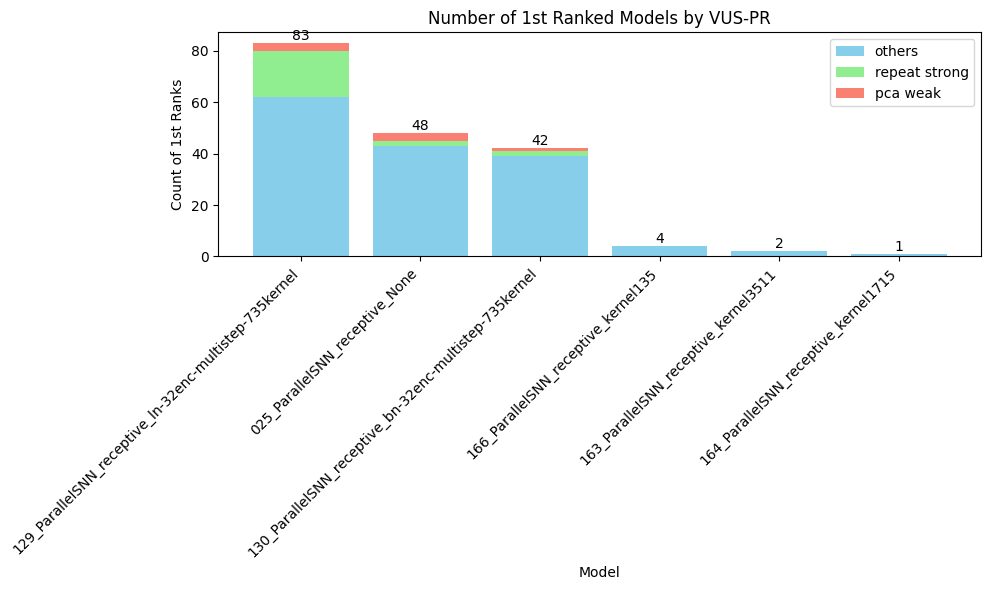

In [492]:
plot_number_of_1st_ranked(red_files=red_files, green_files=green_files)

,025_ParallelSNN_receptive_None,129_ParallelSNN_receptive_ln-32enc-multistep-735kernel,130_ParallelSNN_receptive_bn-32enc-multistep-735kernel,163_ParallelSNN_receptive_kernel3511,164_ParallelSNN_receptive_kernel1715,165_ParallelSNN_receptive_kernel357,166_ParallelSNN_receptive_kernel135,167_ParallelSNN_receptive_ln-k735-gradSpike
Dataset,,,,,,,,
001_Genesis_id_1_Sensor_tr_4055_1st_15538.csv,0.030422,0.101556,0.061817,0.087589,0.057703,0.061294,0.062321,0.086374
002_MSL_id_1_Sensor_tr_500_1st_900.csv,0.145078,0.143318,0.141560,0.147264,0.143069,0.144218,0.147362,0.145607
003_MSL_id_2_Sensor_tr_883_1st_1238.csv,0.173604,0.194489,0.186565,0.131638,0.153511,0.134275,0.177005,0.172505
005_MSL_id_4_Sensor_tr_855_1st_2700.csv,0.074290,0.098015,0.068839,0.094132,0.099757,0.095610,0.084896,0.096389
006_MSL_id_5_Sensor_tr_1150_1st_1250.csv,0.107019,0.103399,0.118182,0.110582,0.105191,0.054772,0.115583,0.109195
...,...,...,...,...,...,...,...,...
197_Exathlon_id_24_Facility_tr_10766_1st_12590.csv,0.955514,0.929409,0.947205,NaN,NaN,NaN,NaN,NaN
198_Exathlon_id_25_Facility_tr_12538_1st_12638.csv,0.968420,0.964711,0.932955,NaN,NaN,NaN,NaN,NaN
199_Exathlon_id_26_Facility_tr_12538_1st_12638.csv,0.956661,0.937618,0.951545,NaN,NaN,NaN,NaN,NaN


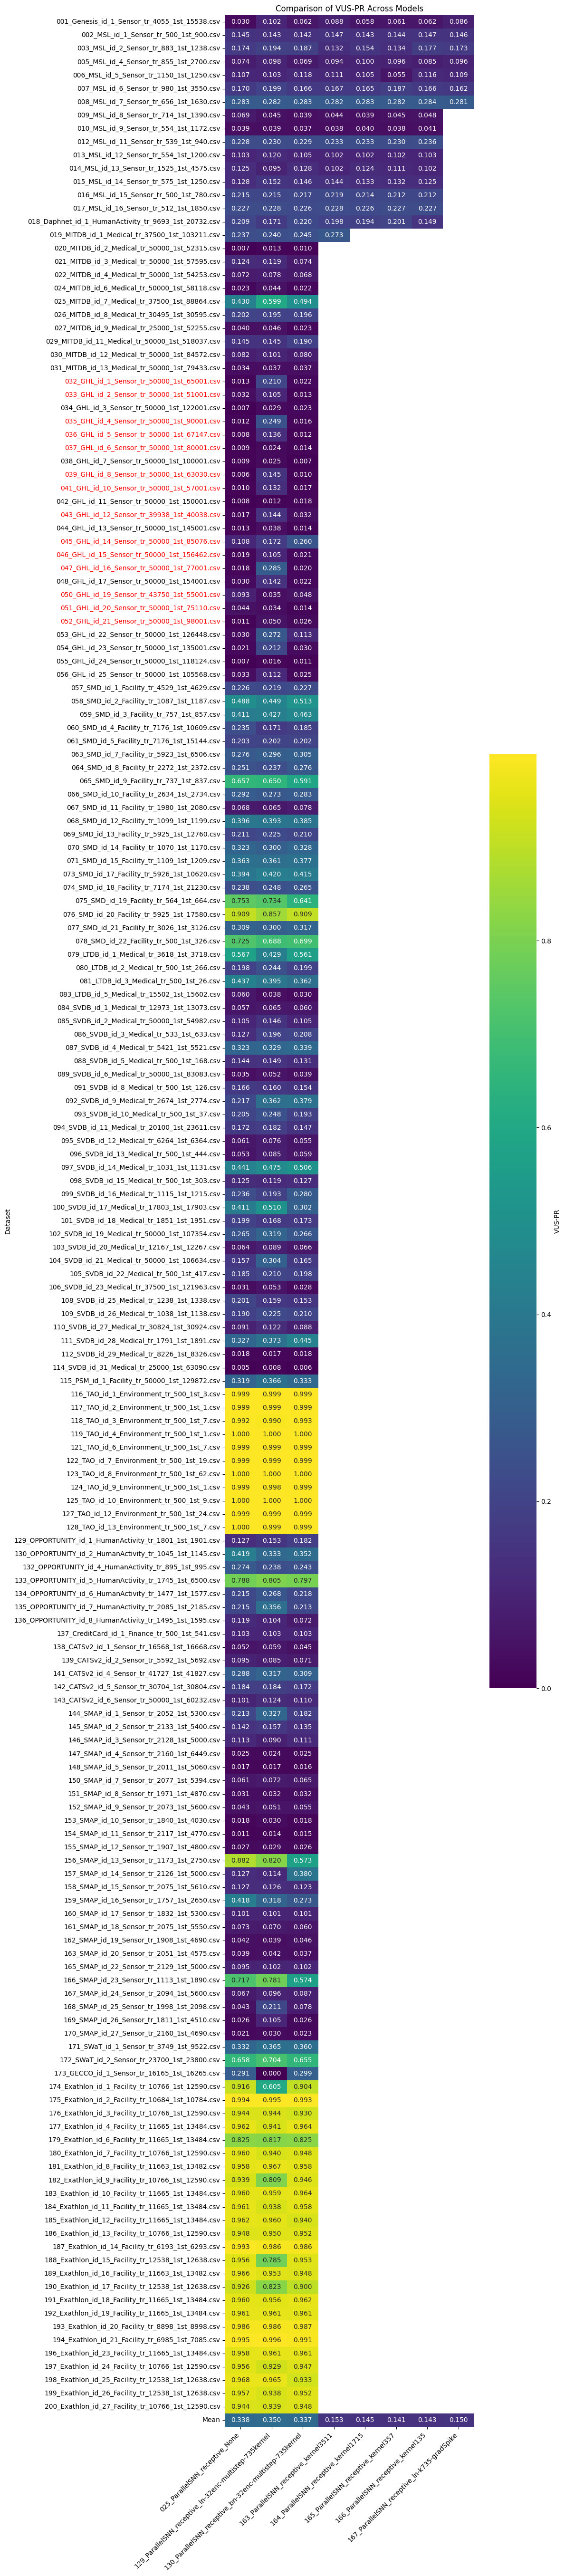

In [493]:
changed_files = [
    '032_GHL_id_1_Sensor_tr_50000_1st_65001.csv',
    '033_GHL_id_2_Sensor_tr_50000_1st_51001.csv',
    '035_GHL_id_4_Sensor_tr_50000_1st_90001.csv',
    '036_GHL_id_5_Sensor_tr_50000_1st_67147.csv',
    '037_GHL_id_6_Sensor_tr_50000_1st_80001.csv',
    '039_GHL_id_8_Sensor_tr_50000_1st_63030.csv',
    '041_GHL_id_10_Sensor_tr_50000_1st_57001.csv',
    '043_GHL_id_12_Sensor_tr_39938_1st_40038.csv',
    '045_GHL_id_14_Sensor_tr_50000_1st_85076.csv',
    '046_GHL_id_15_Sensor_tr_50000_1st_156462.csv',
    '047_GHL_id_16_Sensor_tr_50000_1st_77001.csv',
    '051_GHL_id_20_Sensor_tr_50000_1st_75110.csv',
    '052_GHL_id_21_Sensor_tr_50000_1st_98001.csv',
    '050_GHL_id_19_Sensor_tr_43750_1st_55001.csv',
]
plot_performance_heatmap(red_files=changed_files, highlight_only=False)

/tmp/ipykernel_148687/1821109622.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


,025_ParallelSNN_receptive_None,129_ParallelSNN_receptive_ln-32enc-multistep-735kernel,130_ParallelSNN_receptive_bn-32enc-multistep-735kernel,163_ParallelSNN_receptive_kernel3511,164_ParallelSNN_receptive_kernel1715,165_ParallelSNN_receptive_kernel357,166_ParallelSNN_receptive_kernel135,167_ParallelSNN_receptive_ln-k735-gradSpike
Dataset,,,,,,,,
065_SMD_id_9_Facility_tr_737_1st_837.csv,0.657487,0.650333,0.590702,NaN,NaN,NaN,NaN,NaN
073_SMD_id_17_Facility_tr_5926_1st_10620.csv,0.393523,0.419861,0.414512,NaN,NaN,NaN,NaN,NaN
078_SMD_id_22_Facility_tr_500_1st_326.csv,0.724765,0.687671,0.698953,NaN,NaN,NaN,NaN,NaN
115_PSM_id_1_Facility_tr_50000_1st_129872.csv,0.318932,0.366424,0.333185,NaN,NaN,NaN,NaN,NaN
130_OPPORTUNITY_id_2_HumanActivity_tr_1045_1st_1145.csv,0.418866,0.332937,0.352425,NaN,NaN,NaN,NaN,NaN
144_SMAP_id_1_Sensor_tr_2052_1st_5300.csv,0.212740,0.327131,0.181823,NaN,NaN,NaN,NaN,NaN
173_GECCO_id_1_Sensor_tr_16165_1st_16265.csv,0.291204,0.000000,0.299013,NaN,NaN,NaN,NaN,NaN
Mean,0.431074,0.397765,0.410087,NaN,NaN,NaN,NaN,NaN


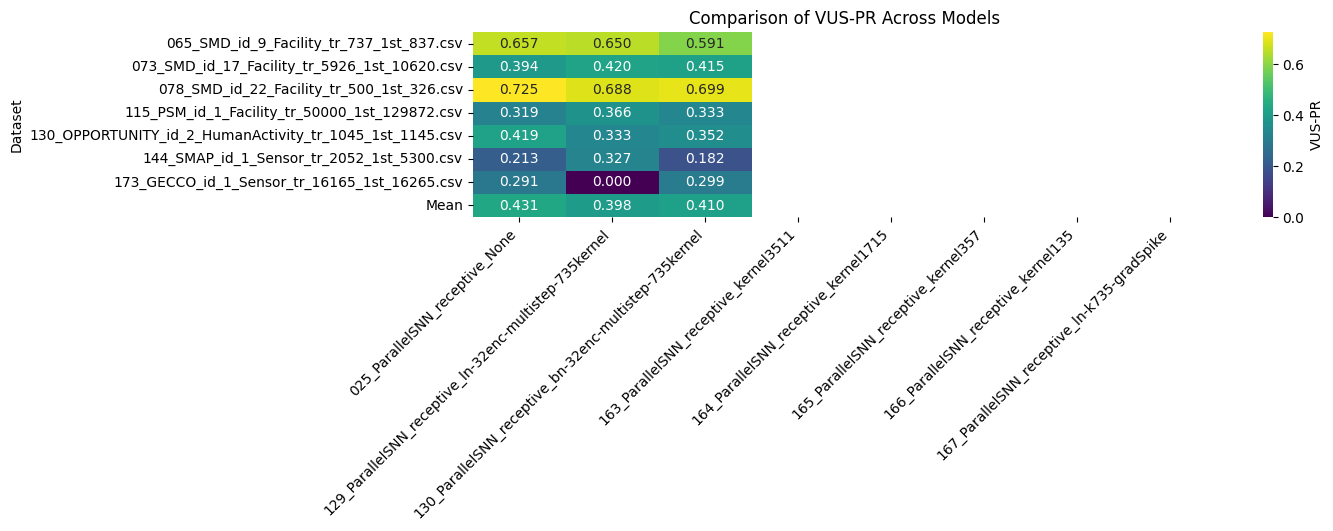

In [494]:
plot_performance_heatmap(red_files=red_files, highlight_only=True)